This notebook demonstrates how to use Pyriod to measure Observed-Calculated (O-C) diagrams for variable sources. These diagrams record timing variations compared with expectations for a strictly periodic signal. This works when the timescale for frequency variations is much longer than the intrinsic period. Some applications include measuring slow drifts in intrinsic periodicity, or looking for periodic variations from varying Doppler shifts through orbital motion. With Pyriod, these timing variations are measured as variations in signal phase at time t=0 for variability modeled as a fixed-frequency sinusoid [(e.g., Dalessio et al. 2013)](https://ui.adsabs.harvard.edu/abs/2013ASPC..469...45D/abstract).

The demonstration is based on code developed for the paper "Gravitational Influence from Planets on the Measured Rates of Period Change
of Pulsating White Dwarfs" by Yao, Bell, and Dublin (submitted). Thanks to Ling Xuan Yao for developing the original code.

Here we demonstrate data similar to the pulsating white dwarf G117-B15A, the most stable optical clock known, which has been monitored for over 50 years [(Kepler et al. 2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...906....7K/abstract). We simulate data with a constant rate of period change similarly observed many times over 50 years. We expect the O-C diagram to appear consistent with a parabola for a constant rate of period change.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:8.5e}'.format # Display small numbers with scientific notation
import lightkurve as lk
from Pyriod import Pyriod
from astropy import constants as c, units as u
from astropy.coordinates import Angle

<Figure size 640x480 with 0 Axes>

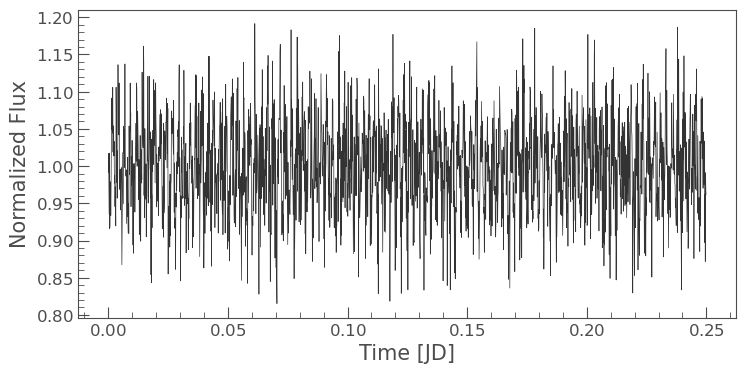

In [2]:
# Here we imagine that multiple light curves are collected for the same target at different times,
# and we wish to measure one O-C value for each light curve.
# A longer continuous light curve could similarly be broken down into shorter segments.
# Code in this cell can be used to generate synthetic data with a constant rate of period change.


# timefunction produces the structured timestamps for nobs number of individual continuous light 
# curves (with given duration and cadence), each separated in time by spacingbetween.

def timefunction(nobs = 50, spacingbetween = 28*u.day, duration = 1*u.day, cadence = 60*u.s):
    """Generate timestamps for a series of simulated light curves.

    Simulates a total of "nobs" individual light curves separated in time by "spacingbetween".
    Each light curve has a duration of "duration" with individual data points sampled every "cadence".
    Default values will produce timestamps for 50 light curves, separated by 28 days, each sampled
    every 60 seconds for a durations of 1 day.
    
    Args:
        nobs: number of continuous light curves to generate. (integer; default: 50)
        spacingbetween: time spacing between each epoch of continuous observation (astropy time units; default: 28 days)
        duration: length of each individual light curve (astropy time units; default: 1 day)
        cadence: spacing between observations within a light curve (astropy time units; default: 60 seconds)
    
    Returns:
        A list of time arrays for each individual light curve (with astropy units of days)
    """
    # Each light curve has same duration and cadence
    eachlc = np.arange(int((duration/cadence).decompose().value))*cadence
    # Repeat light curves nobs times every spacingbetween
    times = [(i*spacingbetween+eachlc).to(u.d) for i in range(nobs)]
    return times

# constantpdot_flux simulates flux measurements at given timestamps for a sinusoidal variation with a
# constant rate of period change (P-dot). The reference period is the intrinsic period at time t=0.

def constantpdot_flux(times, pulsationperiod = 215*u.s, pdot = 5e-15, pulsationamplitude = 0.05, noiselevel = 0.01): 
    """Generate light curve flux values for a pulsating star with a constant rate of period change.

    For a list of time arrays (individual light curves with astropy units), simulate data for a sinusoidal variable 
    with a graduatlly changing period.
    
    Args:
        times: list of timestamp arrays for each light curve to be generated (list of arrays with astropy time units)
        pulsationperiod: period of the intrinsic sinusoidal signal (with astropy time units; default: 215 s)
        pdot: unitless rate of pulsation period change with time (float; default 5*10^-15)
        pulsationamplitude: relative fractional semi-amplitude of pulsational variability (float; default: 0.05)
        noiselevel: scale of point-by-point Gaussian noise (float; default: 0.01)
    Returns:
        A list of lightkurve.LightCurve objects for each individual light curve.
    """
    # convert pulsation period to days
    P = pulsationperiod.to(u.d).value
    # Make empty list to store light curves
    lightcurves = []
    # Loop over arrays of timestamps and generate lightcurves for each
    for timestamps in times:
        # sinusoid with period varying with time
        signal = pulsationamplitude*np.sin(np.pi + 2*np.pi*(timestamps.value) / (P + pdot*timestamps.value)) + 1 # Normalized to 1
        noise = noiselevel*np.random.randn(len(timestamps)) # Gaussian measurement noise
        lightcurves.append(lk.LightCurve(time=timestamps, flux = signal+noise, flux_err=noiselevel).normalize())
    return lightcurves

# Example data for this tutorial...
duration = 0.25*u.day # 6 hours of observations
cadence = 10*u.s # sampled every 10 second
spacingbetween = 1*u.yr # observed once per year
nobs = 50 # for 50 years
pulsationperiod = 215*u.s # 215-second pulsation period, similar to G117-B15A
pdot = 5e-15 # similar to G117-B15A
pulsationamplitude = 0.05 # 5% photometric semi-amplitude
noiselevel = 0.05 # 5% per-point noise

times = timefunction(nobs, spacingbetween, duration, cadence) # generate timestamps
lcs = constantpdot_flux(times, pulsationperiod, pdot, pulsationamplitude, noiselevel) # generate light curves

# Show one light curve
plt.figure()
lcs[0].plot()
plt.show()

In [3]:
# Measure O-C for each light curve via phase variations with Pyriod
# use the intrinsic period for the reference period

def OC(lightcurves, referenceperiod):
    """Measure Observed-Calculated of a sinusoidal signal across a series of light curves.
    
    Measure variations in signal arrival time (Observed) compared to a constant reference period (Calculated)
    using phase variations measured with the Pyriod frequency analysis code. One timing data point is collected
    for each light curve provided in a list.
    
    Args:
        lightcurves: list of lightkurve.LightCurve objects, for O-C to be measured from each.
        referenceperiod: reference period for Calculated times (float in units of seconds, or with astropy units)

    Returns:
        pandas DataFrame with average epoch of each light curve (average time divided by reference period), O-C 
        time delay, and O-C uncertainty.

    Notes:
        A correction is attempted when the phase of the signal crosses the 0-2pi boundary. Assumes that signal
        coverage is frequent enought that large jumps in O-C phase (> pi) are not expected.
    """
    # convert reference period to frequency in units of microHz
    if type(referenceperiod) is not u.quantity.Quantity:
        referenceperiod *= u.s
    referencefrequency = (1/referenceperiod).to(u.uHz) # microHz for Pyriod

    # Prepare to collect results
    nlightcurves = len(lightcurves) # number of light curves in list
    meantime = np.zeros(nlightcurves) # array to store phase variations
    phase = np.zeros(nlightcurves) # array to store phase variations
    phaseerr = np.zeros(nlightcurves) # array to store phase errors
    for i in range(nlightcurves): 
        # Make Pyriod instance to measure phase variations
        # Disable GUI functionality (unneeded and slow)
        meantime[i] = np.mean(lightcurves[i].time.value)
        pyriod = Pyriod(lightcurves[i],gui=False,rescale_covar=True, freq_unit = "muHz")  
        pyriod.add_signal(referencefrequency.value,fixfreq=True) # Do not vary frequency in the fit
        pyriod.fit_model() # Fitting sinusoidal model to time series data
        phase[i] = pyriod.fitvalues['phase'].values[0] # record best-fit phase
        phaseerr[i] = pyriod.fitvalues['phaseerr'].values[0] # record uncertainty
    # Format results of O-C
    oc = -np.array(phase)*referenceperiod # Unprocessed O-C signal
    ocerr = np.array(phaseerr)*referenceperiod
    # Apply phase boundary correction
    ind = np.diff(oc) > referenceperiod/2 # Grabbing index where difference between consecutive cells are greater than half the pulsation period
    oc[1:] = oc[1:]-np.cumsum(ind)*referenceperiod # Phase fitting for when phase goes over the boundaries of 2pi. Subtracts the amount of cycles where previous condition (OC>pulsationperiod/2) was fulfilled
    oc -= oc[0] #start at O-C=0
    epoch = (meantime*u.d/referenceperiod).decompose() # Converting time to cycles
    return pd.DataFrame({"Epoch":epoch,"OC": oc,"OC_err": ocerr})

# Run it on our data
ocdata = OC(lcs, referenceperiod=pulsationperiod)

# Show the resulting table
ocdata

,Epoch,OC,OC_err
0,5.02093e+01,0.00000e+00,1.02133e+00
1,1.46830e+05,-4.72908e-01,1.02191e+00
2,2.93609e+05,-8.52696e-01,1.01511e+00
3,4.40389e+05,1.94880e+00,1.09720e+00
4,5.87168e+05,9.14264e-01,1.03845e+00
5,7.33948e+05,1.87691e+00,1.05663e+00
6,8.80727e+05,1.91395e+00,1.03829e+00
7,1.02751e+06,-1.04553e+00,1.03588e+00
8,1.17429e+06,1.14214e+00,1.10708e+00
9,1.32107e+06,2.09360e+00,1.13712e+00


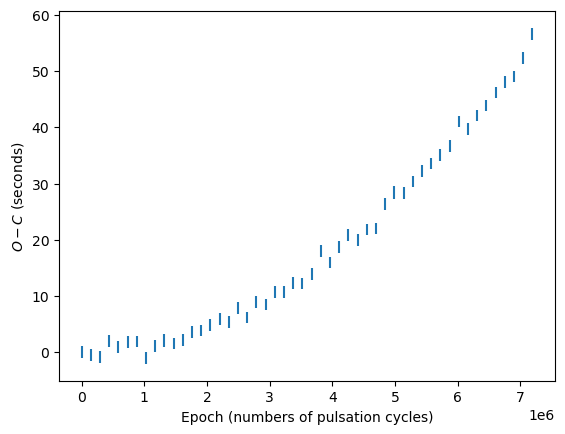

In [4]:
# Plot results
plt.figure()
plt.errorbar(ocdata["Epoch"], ocdata["OC"], ocdata["OC_err"], fmt='None')
plt.xlabel("Epoch (numbers of pulsation cycles)")
plt.ylabel(r"$O-C$ (seconds)")
plt.show()

# As expected, O-C is parabolic for a constant rate of period change.